In [9]:
import os 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu
from tensorflow.keras.optimizers import Adam

def case_preprocessing():
    dataset = list()
    only_train_dataset = list()
    df = pd.DataFrame()
    train_df = pd.DataFrame()   # 새로운 Col 만들기 
    dir_path = 'C:\\Users\\gusrl\\opendrift\\drift_trajection'
    pastDir_path = 'C:\\Users\\gusrl\\opendrift\\drift_trajection\\Past_data'
    
    # hour, wind(바람의 x축,y축 방향 각각 제곱합의 루트), water(해류의 x축,y축 방향 각각 제곱합의 루트)
    for k in range(1,16):
        only_train_dataset.append(pd.read_csv(os.path.join(pastDir_path ,(str(k)+'.csv'))))
                                  
    # 2016 (case 7)
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_003.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_005.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_010.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_011.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_015.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_016.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_040.csv')))

    # 2018(case 12)
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_005.csv')))
    # dataset_list.append(pd.read_csv(os.path.join(dir_path,'2018_case_008.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_017.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_027.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_032.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_034.csv')))
    # dataset_list.append(pd.read_csv(os.path.join(dir_path,'2018_case_045.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_047.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_082.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_083.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_090.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_095.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_097.csv')))

    # 2019(case 4)
    dataset.append(pd.read_csv(os.path.join(dir_path,'2019_case_000.csv')))
#     dataset.append(pd.read_csv(os.path.join(dir_path,'2019_case_001.csv'))) 
    dataset.append(pd.read_csv(os.path.join(dir_path,'2019_case_005.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2019_case_006.csv'))) 
    dataset.append(pd.read_csv(os.path.join(dir_path,'2019_case_007.csv')))  
    
    # 과거데이터 전처리 
    for i in range(len(only_train_dataset)):
        # 시간처리를 위해 time의 object type -> datetime64로 변경
        only_train_dataset[i]['time'] = pd.to_datetime(only_train_dataset[i]['time'],format = '%Y-%m-%d %H:%M', errors = 'raise')
        # hour열 생성
        only_train_dataset[i]['hour'] = only_train_dataset[i]['time'].dt.hour
        # wind 열 생성
        only_train_dataset[i]['wind'] = (only_train_dataset[i]['wind_x']**2 + only_train_dataset[i]['wind_y']**2)**(1/2)
        # water열 생성
        only_train_dataset[i]['water'] = (only_train_dataset[i]['water_velocity_x']**2 + only_train_dataset[i]['water_velocity_y']**2)**(1/2)
        # diff_lon열 생성
        only_train_dataset[i]['diff_lon'] = only_train_dataset[i]['obs_x1_lon'].diff() 
        only_train_dataset[i]['diff_lon'][0] = 0
        # diff_lat열 생성
        only_train_dataset[i]['diff_lat'] = only_train_dataset[i]['obs_x1_lat'].diff()
        only_train_dataset[i]['diff_lat'][0] = 0
        # diff열 생성
        only_train_dataset[i]['diff'] = (only_train_dataset[i]['diff_lon']**2 + only_train_dataset[i]['diff_lat']**2)**(1/2)
        # Null 값 제외
        
        only_train_dataset[i] = only_train_dataset[i].dropna()
        only_train_dataset[i] = only_train_dataset[i].reset_index(drop = True)
        
        
        # 초기좌표 (해역 나누기)
        only_train_dataset[i]['start_lon'] = only_train_dataset[i]['obs_x1_lon'][0]
        only_train_dataset[i]['start_lat'] = only_train_dataset[i]['obs_x1_lat'][0]
        
        # Smoothing (wind_x_ma, wind_y_ma, water_velocity_x_ma, water_velocity_y_ma 인자 추가) 
        only_train_dataset[i]['wind_x_ma'] = 0
        only_train_dataset[i]['wind_y_ma'] = 0
        only_train_dataset[i]['water_velocity_x_ma'] = 0
        only_train_dataset[i]['water_velocity_y_ma'] = 0 
        for j in range(1,len(only_train_dataset[i])-1):
            only_train_dataset[i]['wind_x_ma'][j] = (only_train_dataset[i]['wind_x'][j-1] + only_train_dataset[i]['wind_x'][j] + only_train_dataset[i]['wind_x'][j+1])/3
            only_train_dataset[i]['wind_y_ma'][j] = (only_train_dataset[i]['wind_y'][j-1] + only_train_dataset[i]['wind_y'][j] + only_train_dataset[i]['wind_y'][j+1])/3
            only_train_dataset[i]['water_velocity_x_ma'][j] = (only_train_dataset[i]['water_velocity_x'][j-1] + only_train_dataset[i]['water_velocity_x'][j] + only_train_dataset[i]['water_velocity_x'][j+1])/3
            only_train_dataset[i]['water_velocity_y_ma'][j] = (only_train_dataset[i]['water_velocity_y'][j-1] + only_train_dataset[i]['water_velocity_y'][j] + only_train_dataset[i]['water_velocity_y'][j+1])/3    
        df = only_train_dataset[i]
        indices = df.query('wind_x < -90 or wind_y < -90 or water_velocity_x < -90 or water_velocity_y < -90').index
        df.drop(indices, inplace=True)
        df.reset_index(drop = True, inplace=True)
        only_train_dataset[i] = df 
        
     # 기상청 데이터 전처리 
    for i in range(len(dataset)):
        # 시간처리를 위해 time의 object type -> datetime64로 변경
        dataset[i]['time'] = pd.to_datetime(dataset[i]['time'],format = '%Y-%m-%d %H:%M', errors = 'raise')
        # hour열 생성
        dataset[i]['hour'] = dataset[i]['time'].dt.hour
        # wind 열 생성
        dataset[i]['wind'] = (dataset[i]['wind_x']**2 + dataset[i]['wind_y']**2)**(1/2)
        # water열 생성
        dataset[i]['water'] = (dataset[i]['water_velocity_x']**2 + dataset[i]['water_velocity_y']**2)**(1/2)
        # diff_lon열 생성
        dataset[i]['diff_lon'] = dataset[i]['obs_x1_lon'].diff() 
        dataset[i]['diff_lon'][0] = 0
        # diff_lat열 생성
        dataset[i]['diff_lat'] = dataset[i]['obs_x1_lat'].diff()
        dataset[i]['diff_lat'][0] = 0
        # diff열 생성
        dataset[i]['diff'] = (dataset[i]['diff_lon']**2 + dataset[i]['diff_lat']**2)**(1/2)
        # Null 값 제외
        print('dd', dataset[i].dropna().sum())
        dataset[i] = dataset[i].dropna()
        dataset[i] = dataset[i].reset_index(drop = True)
        
        # 초기좌표 (해역 나누기)
        dataset[i]['start_lon'] = dataset[i]['obs_x1_lon'][0]
        dataset[i]['start_lat'] = dataset[i]['obs_x1_lat'][0]
        
        # Smoothing (wind_x_ma, wind_y_ma, water_velocity_x_ma, water_velocity_y_ma 인자 추가) 
        dataset[i]['wind_x_ma'] = 0
        dataset[i]['wind_y_ma'] = 0
        dataset[i]['water_velocity_x_ma'] = 0
        dataset[i]['water_velocity_y_ma'] = 0 
        for j in range(1,len(dataset[i])-1):
            dataset[i]['wind_x_ma'][j] = (dataset[i]['wind_x'][j-1] + dataset[i]['wind_x'][j] + dataset[i]['wind_x'][j+1])/3
            dataset[i]['wind_y_ma'][j] = (dataset[i]['wind_y'][j-1] + dataset[i]['wind_y'][j] + dataset[i]['wind_y'][j+1])/3
            dataset[i]['water_velocity_x_ma'][j] = (dataset[i]['water_velocity_x'][j-1] + dataset[i]['water_velocity_x'][j] + dataset[i]['water_velocity_x'][j+1])/3
            dataset[i]['water_velocity_y_ma'][j] = (dataset[i]['water_velocity_y'][j-1] + dataset[i]['water_velocity_y'][j] + dataset[i]['water_velocity_y'][j+1])/3
        
        # 삭제 전 원본 df
        df = pd.concat([df,dataset[i]],ignore_index = True)
        # 불필요열 삭제 
        pre_df = dataset[i].drop(columns = ['time','obs_x1_lon','obs_x1_lat','model_x2_lon','model_x2_lat'])  
        train_df = pd.concat([train_df, pre_df[1:-1]],ignore_index = True)
        
    df = df.reset_index(drop = True)
    train_df = train_df.reset_index(drop = True)
    return dataset, df, train_df, only_train_dataset

def drift_mae(y, predict_y):
    mae = mean_absolute_error(y, predict_y)
    return mae


def n2_mae(y, predict_y):
    n = y.shape[0]
    error_sum = 0
    
    for i in range(n):
        error_sum += abs((y[i][0] - predict_y[i][0])) + abs(( y[i][1] - predict_y[i][1]))
    
    mae = error_sum/(2*n)   
    
    return mae


def paper_mae(y, predict_y): # 논문  
    n = y.shape[0]
    error_sum = 0
    
    for i in range(n):
        error_sum += abs(y[i][0] - predict_y[i][0]) + abs(y[i][1] - predict_y[i][1])
    
    mae = error_sum/n    
    return mae

def NCLS_score(y, predict_y): # 1시간 
        # dl_i 구하기 
        dl_list, dl_sum, o_sum = list(), list(), 0
        n = y.shape[0]
        for i in range(1, n):
            # 위도 1도는 111.321, 경도 1도는 87.74km, 단위 km
            d_lon = y[i][0] - y[i-1][0]  
            d_lat = y[i][1] - y[i-1][1]
            # 거리 구하기
            point_distance = np.sqrt(np.power(d_lon,2) + np.power(d_lat,2))
            dl_list.append(point_distance)
            
        for i in range(len(dl_list)):
            temp = 0
            for j in range(i+1):
                temp += dl_list[j]
            dl_sum.append(temp)

        for i in range(len(dl_sum)):
            o_sum += dl_sum[i]
        
        # 예측모델의 d_i 구하기
        d_list = list()
        for i in range(1,n):
            # 위도 1도는 111.321 # 경도 1도는 55.802km
            d_lon = y[i][0] - predict_y[i][0]  
            d_lat = y[i][1] - predict_y[i][1]
            # 거리 구하기
            point_distance = np.sqrt(np.power(d_lon,2) + np.power(d_lat,2))
            d_list.append(point_distance)

        # s 구하기
        d_sum, s, ss_score = 0, 0, 0

        for i in range(len(d_list)):
            d_sum += d_list[i]

        s = d_sum/o_sum
        
        if s > 1:
                ss_score = 0
        else:
            ss_score = 1-s
        
        return ss_score

def drift_trajection_show(index, y_pred): 
    %matplotlib inline

    # 실제 위치
    lon = dataset[index]['obs_x1_lon']
    lon = np.array(lon)
    lat = dataset[index]['obs_x1_lat']
    lat = np.array(lat)
    
    # baseline
    baseline_lon = dataset[index]['model_x2_lon']
    baseline_lon = np.array(baseline_lon)
    baseline_lat = dataset[index]['model_x2_lat']
    baseline_lat = np.array(baseline_lat)

    # 예측값 
    first_lon = lon[0]
    first_lat = lat[0]
    lon_pred = np.zeros((y_pred.shape[0]+1,))
    lat_pred = np.zeros((y_pred.shape[0]+1,))
    lon_pred[0] = first_lon 
    lat_pred[0] = first_lat
    
    for i in range(1, lon_pred.shape[0]):
        lon_pred[i] = lon_pred[i-1] + y_pred[i-1][0]
        lat_pred[i] = lat_pred[i-1] + y_pred[i-1][1]
        
    return lon, lat, baseline_lon, baseline_lat, lon_pred, lat_pred

def std_scaler(train_X, test_X):
    from sklearn.preprocessing import StandardScaler
    std = StandardScaler()
    std.fit(train_X)
    train_X_scaled = std.transform(train_X)
    test_X_scaled = std.transform(test_X)
    return train_X_scaled, test_X_scaled

def MinMax_scaler(train_X, test_X):
    from sklearn.preprocessing import MinMaxScaler
    mms = MinMaxScaler()
    mms.fit(train_X)
    train_X_scaled = mms.transform(train_X)
    test_X_scaled = mms.transform(test_X)
    return train_X_scaled, test_X_scaled
    
def roburst_scaler(train_X, test_X):
    from sklearn.preprocessing import RobustScaler
    rbs = RobustScaler()
    train_X_scaled = rbs.fit_transform(train_X)
    test_X_scaled = rbs.transform(test_X)
    return train_X_scaled, test_X_scaled


def maxAbsScaler(train_X, test_X):
    from sklearn.preprocessing import MaxAbsScaler
    maxAbsScaler = MaxAbsScaler()
    train_X_scaled = maxAbsScaler.fit_transform(train_X)
    test_X_scaled = maxAbsScaler.transform(test_X)
    return train_X_scaled, test_X_scaled

def data_augmenatation(dataset):
    for case in range(len(dataset)):
        df = dataset[case]
        length = len(df)
        index = 1
        for i in range(length-1):
            lon = (dataset[case]['obs_x1_lon'][i] + dataset[case]['obs_x1_lon'][i+1])/2
            lat = (dataset[case]['obs_x1_lat'][i] + dataset[case]['obs_x1_lat'][i+1])/2
            wind_x_mean = (dataset[case]['wind_x'][i] + dataset[case]['wind_x'][i+1])/2
            wind_y_mean = (dataset[case]['wind_y'][i] + dataset[case]['wind_y'][i+1])/2
            water_velocity_y_mean = (dataset[case]['water_velocity_y'][i] + dataset[case]['water_velocity_y'][i+1])/2
            water_velocity_x_mean = (dataset[case]['water_velocity_x'][i] + dataset[case]['water_velocity_x'][i+1])/2
            
            new_row = {'obs_x1_lon':lon, 'obs_x1_lat':lat,'wind_x':wind_x_mean, 'wind_y':wind_y_mean, 'water_velocity_y':water_velocity_y_mean, 'water_velocity_x':water_velocity_x_mean}
            temp1 = df[df.index < index]
            temp2 = df[df.index >= index]
            df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
            df.reset_index(drop = True, inplace=True)
            index += 2
                # diff_lon열 생성
        df['diff_lon'] = df['obs_x1_lon'].diff() 
        df['diff_lon'][0] = 0
        # diff_lat열 생성
        df['diff_lat'] = df['obs_x1_lat'].diff()
        df['diff_lat'][0] = 0
        dataset[case] = df

In [10]:
dataset, concat_df, train_df, only_train_dataset = case_preprocessing()

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_dataset[i]['diff_lon'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_dataset[i]['diff_lat'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_data

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_dataset[i]['wind_x_ma'][j] = (only_train_dataset[i]['wind_x'][j-1] + only_train_dataset[i]['wind_x'][j] + only_train_dataset[i]['wind_x'][j+1])/3
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_dataset[i]['wind_y_ma'][j] = (only_train_dataset[i]['wind_y'][j-1] + only_train_dataset[i]['wind_y'][j] + only_train_dataset[i]['wind_y'][j+1])/3
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:93: SettingWithCopyW

dd obs_x1_lon          9365.471710
obs_x1_lat          2625.377980
model_x2_lon        9397.252120
model_x2_lat        2619.735677
wind_y              -223.128525
wind_x              -169.814762
water_velocity_y       3.104966
water_velocity_x      -1.261281
hour                 828.000000
wind                 471.798834
water                  6.922849
diff_lon              -0.860890
diff_lat              -0.137430
diff                   1.260368
dtype: float64
dd obs_x1_lon          9385.393560
obs_x1_lat          2611.544350
model_x2_lon        9345.924320
model_x2_lat        2591.911581
wind_y                 7.113362
wind_x                 4.561414
water_velocity_y      -4.096806
water_velocity_x      -6.013417
hour                 828.000000
wind                 192.566420
water                 14.714293
diff_lon               0.689340
diff_lat               0.263490
diff                   0.975133
dtype: float64
dd obs_x1_lon          9402.538710
obs_x1_lat          2670.197370
m

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['diff_lon'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['diff_lat'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:120: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this w

dd obs_x1_lon          9058.657890
obs_x1_lat          2281.462380
model_x2_lon        9056.413598
model_x2_lat        2277.826964
wind_y               338.085696
wind_x               135.699773
water_velocity_y       0.366479
water_velocity_x      12.531978
hour                 828.000000
wind                 376.312723
water                 29.193294
diff_lon               0.766150
diff_lat               0.613350
diff                   1.285950
dtype: float64
dd obs_x1_lon          8750.861300
obs_x1_lat          2375.064570
model_x2_lon        8755.964111
model_x2_lat        2377.837364
wind_y                24.185945
wind_x              -476.354814
water_velocity_y      13.953540
water_velocity_x       2.706847
hour                 809.000000
wind                 513.152632
water                 22.842899
diff_lon              -0.386500
diff_lat               0.494800
diff                   1.008887
dtype: float64
dd obs_x1_lon          8994.496320
obs_x1_lat          2497.459090
m

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff_lon'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff_lat'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: F

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff_lon'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff_lat'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: F

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff_lon'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:306: SettingWithCopyWarning: 
A value is trying 

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = temp1.append(new_row,ignore_index=True).append(temp2, ignore_index=True)
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\3929752181.py:298: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_model'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['model_x2_lon','model_x2_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame



C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_model'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['model_x2_lon','model_x2_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:86: SettingWith

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'] = start_lon
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'] = start_lat
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_model'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['model_x2_lon','model_x2_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:86: SettingWith

C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
C:\Users\gusrl\AppData\Local\Temp\ipykernel_23584\1613028960.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

------------------------ Model  0 ------------------------
baseline 0  MAE :  0.2880089916705404
Model 0  MAE :  0.2775706597222227
baseline 0  NCLS :  0.2578343637823395
Model 0  NCLS :  0.19858270654592725
------------------------ Model  1 ------------------------
baseline 1  MAE :  0.32745050408079857
Model 1  MAE :  0.4105121875000021
baseline 1  NCLS :  0
Model 1  NCLS :  0.12459500351155339
------------------------ Model  2 ------------------------
baseline 2  MAE :  0.3472866207649785
Model 2  MAE :  0.35204785416666873
baseline 2  NCLS :  0.303683671695795
Model 2  NCLS :  0.31510506274052796
------------------------ Model  3 ------------------------
baseline 3  MAE :  0.07788329510834102
Model 3  MAE :  0.23924403521126655
baseline 3  NCLS :  0
Model 3  NCLS :  0.6243207477289584
------------------------ Model  4 ------------------------
baseline 4  MAE :  0.26706784715770315
Model 4  MAE :  0.1435844929577459
baseline 4  NCLS :  0.6956370589263559
Model 4  NCLS :  0.416186203

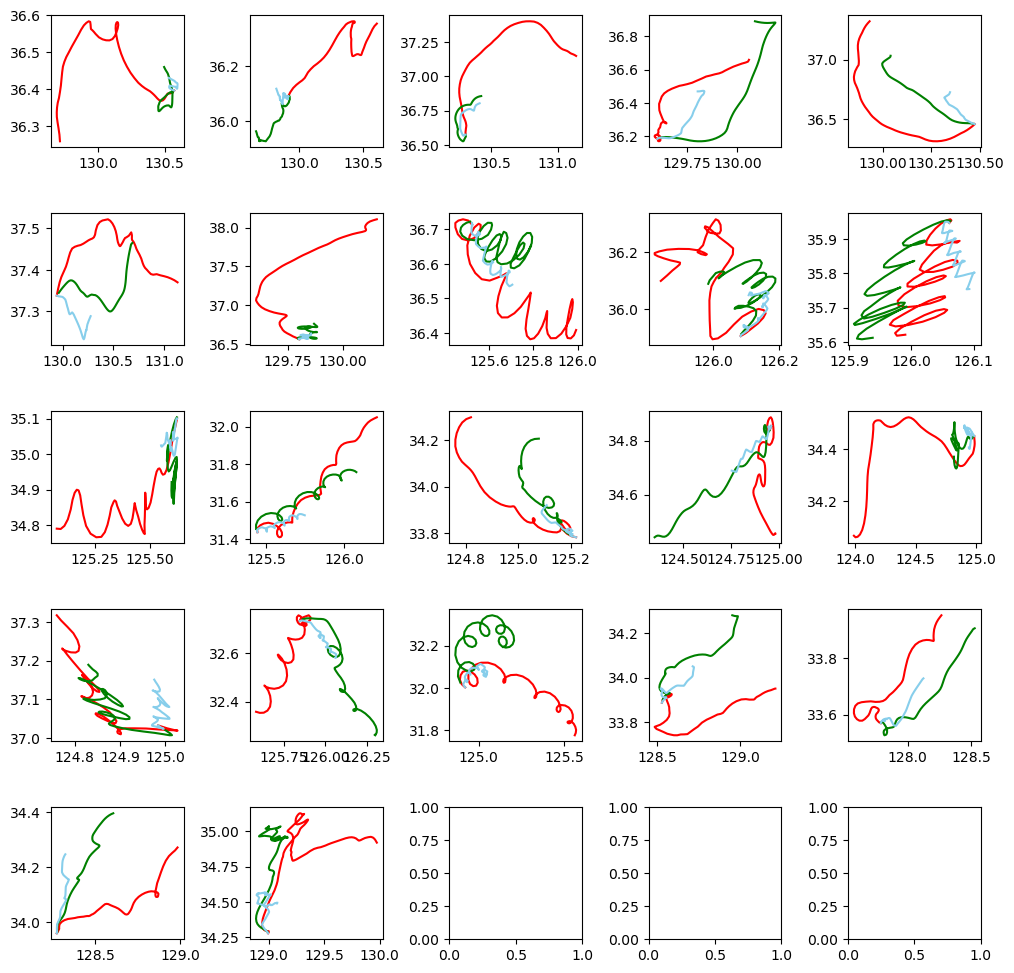

In [11]:
# RandomForest model (Feature 4개) & roburst & 과거 데이터 (훈련 데이터에 추가)
from sklearn.ensemble import RandomForestRegressor
f, axes = plt.subplots(5, 5)
# 격자 크기 설정
f.set_size_inches((12, 12))
# 격자 여백 설정
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
baseline_MAE_list = list() 
baseline_NCLS_list = list()
MAE_list = list()
NCLS_list = list()
test_case_list = list()

# 데이터 추가
data_augmenatation(dataset)
data_augmenatation(only_train_dataset)

for i in range(len(dataset)):
    # train dataset
    train_X = pd.DataFrame()
    train_y = np.array([[]])
    train = dataset[0:i] + dataset[i+1:len(dataset)]

    train_X = train[0][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x']]
    train_y = train[0][['diff_lon', 'diff_lat']]
    # 첫 행은 훈련에서 제외
    train_X = train_X[1:]
    train_y = train_y[1:].to_numpy()
    
    for j in range(1,len(train)):
        trina_xi = train[j][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x']] 
        trina_yi = train[j][['diff_lon', 'diff_lat']]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
        
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0)
    
    # 과거 데이터 훈련데이터에 추가
    for k in range(len(only_train_dataset)):
        trina_xi = only_train_dataset[k][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x']] 
        trina_yi = only_train_dataset[k][['diff_lon', 'diff_lat']]
        trina_xi = trina_xi[1:]
        trina_yi = trina_yi[1:].to_numpy()
        
        train_X = pd.concat([train_X,trina_xi],ignore_index = True)
        train_y = np.concatenate((train_y,trina_yi), axis = 0)
    
    # Test dataset
    test = dataset[i]
    start_lon = dataset[i]['start_lon'][0]
    start_lat = dataset[i]['start_lat'][0]
    
    test_X = test[['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x']]
    test_X = test_X[1:]
    test_y = test[['diff_lon', 'diff_lat']]
    test_y = test_y[1:].to_numpy()
    
    train_X, test_X = roburst_scaler(train_X, test_X)
    # Random Forest 모델 생성
    RD = RandomForestRegressor(max_depth = 5, n_estimators = 100 )
    RD.fit(train_X, train_y)
    
    # model save
    #linear.save(str(i)+'RDF_model.h5')

    # Predict
    y_pred = RD.predict(test_X)
    dataset[i] = dataset[i][::2]
    dataset[i] = dataset[i].reset_index(drop=True)
    y_pred = y_pred[::2]
    test_X = test_X[::2]
    test_y = test_y[::2]
    
    # 행단위로 살펴보기
    test_case_df = dataset[i][['time', 'obs_x1_lon', 'obs_x1_lat', 'wind_y','wind_x','water_velocity_y','water_velocity_x','model_x2_lon', 'model_x2_lat']]
    test_case_df['rf_lon'] = start_lon
    test_case_df['rf_lat'] = start_lat
    test_case_df['ncls_model'] = 0
    test_case_df['ncls_rf'] = 0
    
    # case 별로 이상행 탐색
    for k in range(1,len(test_case_df)-1):
        test_case_df['rf_lon'][k] = test_case_df['rf_lon'][k-1] + y_pred[k][0]
        test_case_df['rf_lat'][k] = test_case_df['rf_lat'][k-1] + y_pred[k][1]
        test_case_df['ncls_model'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['model_x2_lon','model_x2_lat']][:k+1].to_numpy())
        test_case_df['ncls_rf'][k] = NCLS_score(test_case_df[['obs_x1_lon','obs_x1_lat']][:k+1].to_numpy(), test_case_df[['rf_lon','rf_lat']][:k+1].to_numpy())
    
    test_case_df['rf_diff_lon'] = test_case_df['rf_lon'].diff()
    test_case_df['rf_diff_lon'][0] = 0
    test_case_df['rf_diff_lat'] = test_case_df['rf_lat'].diff()  
    test_case_df['rf_diff_lat'][0] = 0
    test_case_df['model_diff_lon'] = test_case_df['model_x2_lon'].diff() 
    test_case_df['model_diff_lon'][0] = 0
    test_case_df['model_diff_lat'] = test_case_df['model_x2_lat'].diff()
    test_case_df['model_diff_lat'][0] = 0
    
    test_case_list.append(test_case_df)
#     # Plot
    lon, lat, baseline_lon, baseline_lat, lon_pred, lat_pred = drift_trajection_show(i,y_pred)
    row = i//5
    col = i%5
    axes[row][col].plot(lon, lat,'r-' ,baseline_lon, baseline_lat, 'g-', lon_pred, lat_pred, 'skyblue')   
    
    # evaluation 
    y = np.concatenate((lon.reshape((lon.shape[0],1)), lat.reshape((lat.shape[0],1))),axis = 1)
    pred = np.concatenate((lon_pred.reshape((lon_pred.shape[0],1)), lat_pred.reshape((lat_pred.shape[0],1))),axis =1)
    baseline_pred = np.concatenate((baseline_lon.reshape((baseline_lon.shape[0],1)), baseline_lat.reshape((baseline_lat.shape[0],1))),axis =1)
    
    #mae
    MAE_list.append(drift_mae(y, pred))
    baseline_MAE_list.append(drift_mae(y, baseline_pred))
    
    
    #NCLS
    NCLS_list.append(NCLS_score(y, pred))
    baseline_NCLS_list.append(NCLS_score(y, baseline_pred))

for i in range(len(MAE_list)):
    print('------------------------ Model ', i, '------------------------')
    print('baseline',str(i),' MAE : ',MAE_list[i])
    print('Model',str(i),' MAE : ', baseline_MAE_list[i])
    print('baseline',str(i),' NCLS : ',baseline_NCLS_list[i])
    print('Model',str(i),' NCLS : ', NCLS_list[i])
    

plt.show()

In [12]:
# 특성 4개 & roburst & 과거데이터 추가
mae_sum = 0
NCLS_sum = 0
for i in range(len(dataset)):
    mae_sum += MAE_list[i]
    NCLS_sum += NCLS_list[i]


# 라이브러리 Mae    
print ('평균 Mae : ', mae_sum/len(dataset) )
print ('평균 NCLS : ', NCLS_sum/len(dataset) )

평균 Mae :  0.20058707400993828
평균 NCLS :  0.5040189458524232
